In [167]:

#couple of packages that we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
import talib


In [168]:
#getting data for specific stock
stock = yf.Ticker('AAPL')
my_data = stock.history(interval='1m', period='8d')


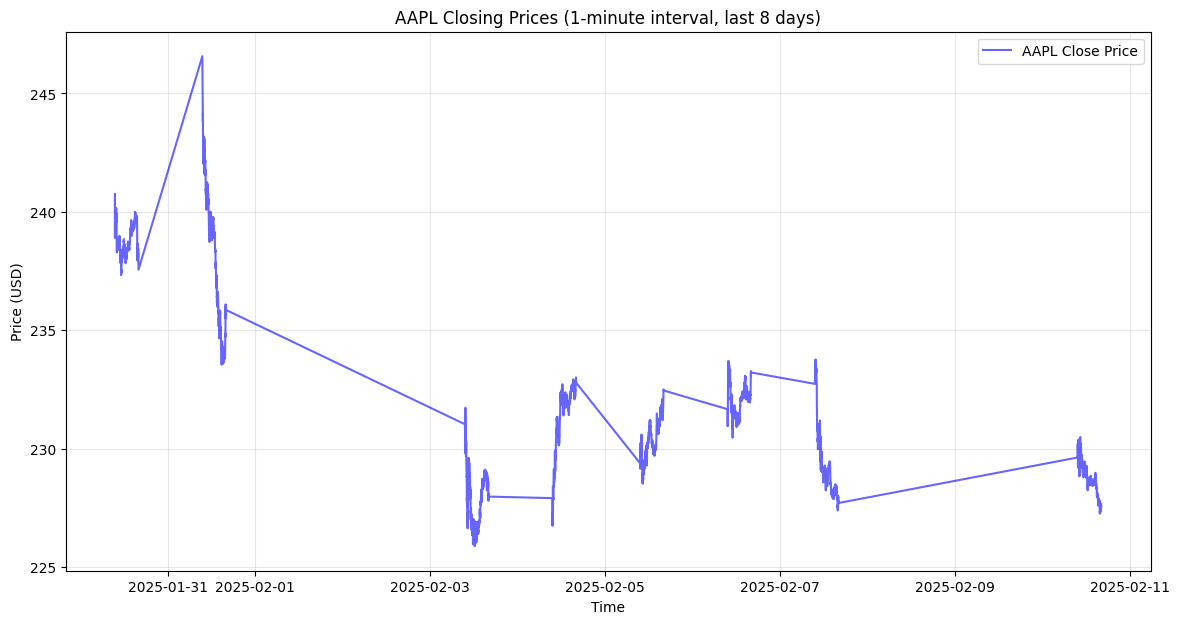

In [169]:
#plot data for Apple(example symbol)
plt.figure(figsize=(14, 7))
plt.plot(my_data.index, my_data['Close'], label='AAPL Close Price', color='blue', alpha=0.6)
plt.title("AAPL Closing Prices (1-minute interval, last 8 days)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [170]:
#function for calculating Mcginely Dynamic Indicator
def mcginley_dynamic(prices, smoothing=10):
   md = [prices.iloc[0]] 
   for price in prices.iloc[1:]: 
       md.append(md[-1] + (price - md[-1]) / (smoothing * (price / md[-1])**4))
   return md

In [171]:
#adding mcginely Dynamic Indicator + Parabolic SAR to the data
my_data['SAR'] = talib.SAR(my_data['High'], my_data['Low'], acceleration=0.02, maximum=0.2)
my_data['McGinley'] = mcginley_dynamic(my_data['Close'])
my_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SAR,McGinley
Datetime,,,,,,,,,
2025-02-10 15:55:00-05:00,227.630005,227.750000,227.509995,227.520996,161410,0.0,0.0,227.250000,227.546625
2025-02-10 15:56:00-05:00,227.520004,227.610001,227.490005,227.580002,178368,0.0,0.0,227.262600,227.549961
2025-02-10 15:57:00-05:00,227.580002,227.658203,227.500000,227.572800,156138,0.0,0.0,227.274948,227.552244
2025-02-10 15:58:00-05:00,227.585007,227.639999,227.505005,227.520004,233291,0.0,0.0,227.287049,227.549018
2025-02-10 15:59:00-05:00,227.509995,227.699997,227.429993,227.639999,520338,0.0,0.0,227.298908,227.558102


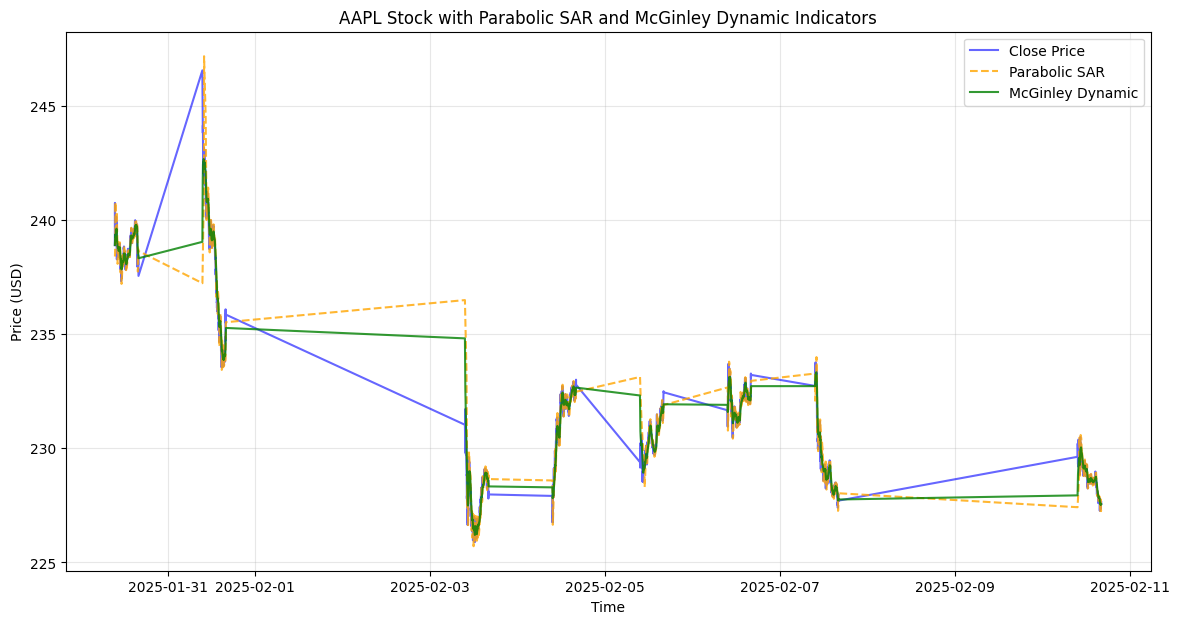

In [172]:
#plot the new data with mcginely indicator + Parabolic SAR Data
plt.figure(figsize=(14, 7))
plt.plot(my_data.index, my_data['Close'], label='Close Price', color='blue', alpha=0.6)

plt.plot(my_data.index, my_data['SAR'], label='Parabolic SAR', linestyle='--', color='orange', alpha=0.8)

plt.plot(my_data.index, my_data['McGinley'], label='McGinley Dynamic', color='green', alpha=0.8)

plt.title("AAPL Stock with Parabolic SAR and McGinley Dynamic Indicators")
plt.xlabel("Time")
plt.ylabel("Price (USD)")

plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [173]:
#Global Variables store profit and signals
profit = 0.0
buy_prices = []
sell_prices = []

In [174]:
#Function To Generate the Signals to Buy or Sell based on SAR and McGinely Dynamic Indicators
def generate_signals(row):
   global buy_prices, sell_prices, profit
  
   # Initialize buy and sell prices
   buy_price = np.nan
   sell_price = np.nan
   if row['SAR'] < row['Close'] and row['McGinley'] < row['Close'] and len(buy_prices) == len(sell_prices):
       buy_price = row['Close']
       buy_prices.append(buy_price)  # Record the buy price
       return 'Buy', buy_price, sell_price
   elif row['SAR'] > row['Close'] and row['McGinley'] > row['Close'] and len(buy_prices) > len(sell_prices):
       sell_price = row['Close']
       sell_prices.append(sell_price)  # Record the sell price
       profit = profit + sell_price - buy_prices[-1]
       return 'Sell', buy_price, sell_price
  
   # Default case: Hold signal
   return 'Hold', buy_price, sell_price

In [175]:
#Run the Algorithim on Apple and Calculate Profit(very bad for short time period)
my_data[['Signal', 'Buy Price', 'Sell Price']] = my_data.apply(generate_signals, axis=1, result_type='expand')
print(profit)

-17.613632202148438


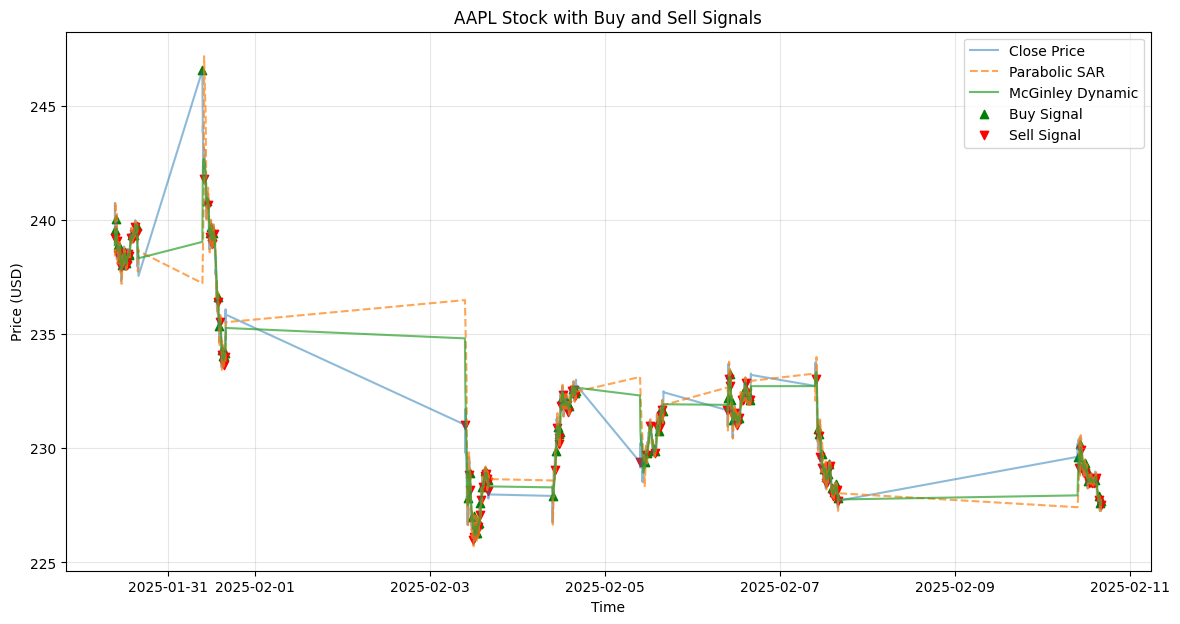

In [176]:
plt.figure(figsize=(14, 7))


plt.plot(my_data['Close'], label='Close Price', alpha=0.5)


plt.plot(my_data['SAR'], label='Parabolic SAR', linestyle='--', alpha=0.7)


plt.plot(my_data['McGinley'], label='McGinley Dynamic', alpha=0.7)


buy_signals = my_data[my_data['Signal'] == 'Buy']
sell_signals = my_data[my_data['Signal'] == 'Sell']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', alpha=1)

# Add title, labels, and legend
plt.title("AAPL Stock with Buy and Sell Signals")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend(loc='best')  # Ensure the legend appears with all labels
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [177]:
#adjust data for long term strategy
stock = yf.Ticker('AAPL')
my_data = stock.history(interval='1h', period='1y')

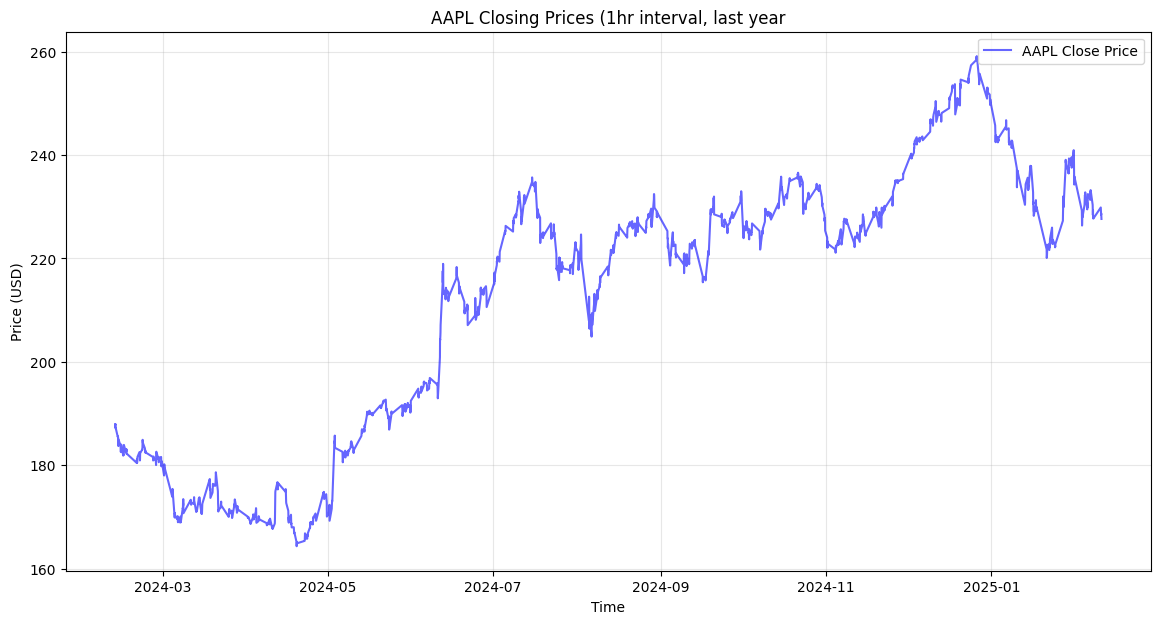

In [178]:
#plot data again for yearly data
plt.figure(figsize=(14, 7))
plt.plot(my_data.index, my_data['Close'], label='AAPL Close Price', color='blue', alpha=0.6)
plt.title("AAPL Closing Prices (1hr interval, last year")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [179]:
#do entire strategy function(easier to iterate for multiple symbols)
def do_strat_from_ticker_minute_wise(ticker):
   stock = yf.Ticker(ticker)
   my_data = stock.history(interval='1m', period='8d')
   my_data['SAR'] = talib.SAR(my_data['High'], my_data['Low'], acceleration=0.02, maximum=0.2)
   my_data['McGinley'] = mcginley_dynamic(my_data['Close'])
   return my_data

def do_strat_from_ticker_hourly_wise(ticker):
   stock = yf.Ticker(ticker)
   my_data = stock.history(interval='1h', period='1y')
   my_data['SAR'] = talib.SAR(my_data['High'], my_data['Low'], acceleration=0.02, maximum=0.2)
   my_data['McGinley'] = mcginley_dynamic(my_data['Close'])
   return my_data

In [180]:
profit = 0.0
buy_prices = []
sell_prices = []
my_data = do_strat_from_ticker_hourly_wise('AAPL')
my_data[['Signal', 'Buy Price', 'Sell Price']] = my_data.apply(generate_signals, axis=1, result_type='expand')
print(profit)

15.832794189453125


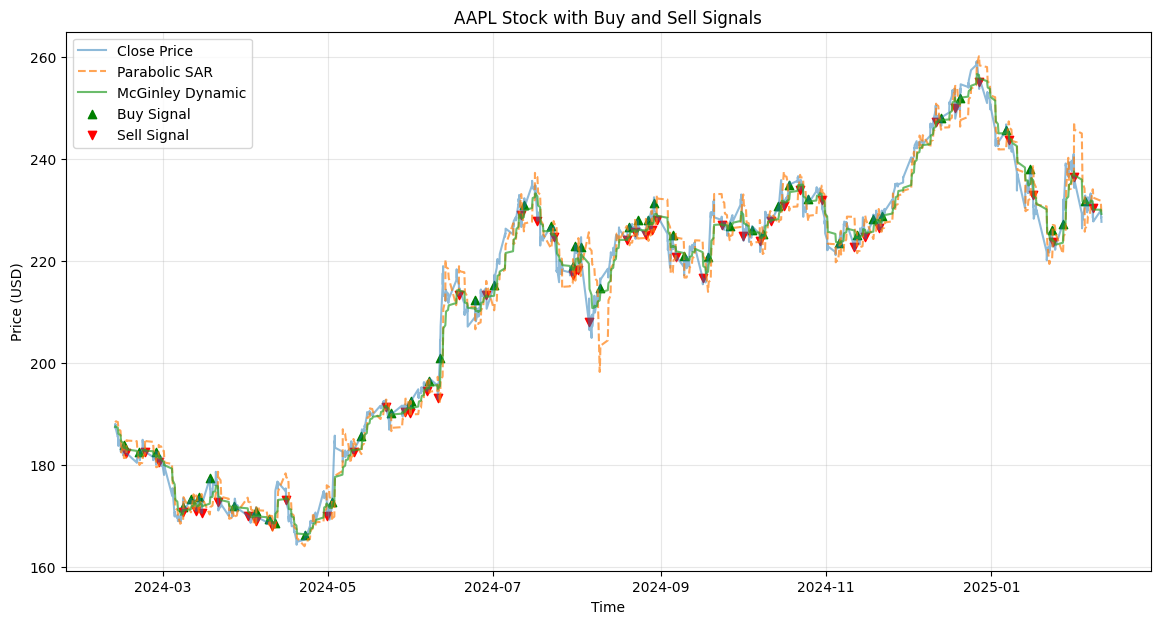

In [181]:
#Works with strong uptrend
plt.figure(figsize=(14, 7))


plt.plot(my_data['Close'], label='Close Price', alpha=0.5)


plt.plot(my_data['SAR'], label='Parabolic SAR', linestyle='--', alpha=0.7)


plt.plot(my_data['McGinley'], label='McGinley Dynamic', alpha=0.7)


buy_signals = my_data[my_data['Signal'] == 'Buy']
sell_signals = my_data[my_data['Signal'] == 'Sell']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', alpha=1)

# Add title, labels, and legend
plt.title("AAPL Stock with Buy and Sell Signals")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend(loc='best')  # Ensure the legend appears with all labels
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [182]:
#works even downtrends also
profit = 0.0
buy_prices = []
sell_prices = []
my_data = do_strat_from_ticker_hourly_wise('DIS')
my_data[['Signal', 'Buy Price', 'Sell Price']] = my_data.apply(generate_signals, axis=1, result_type='expand')
print(profit)

13.311714172363281


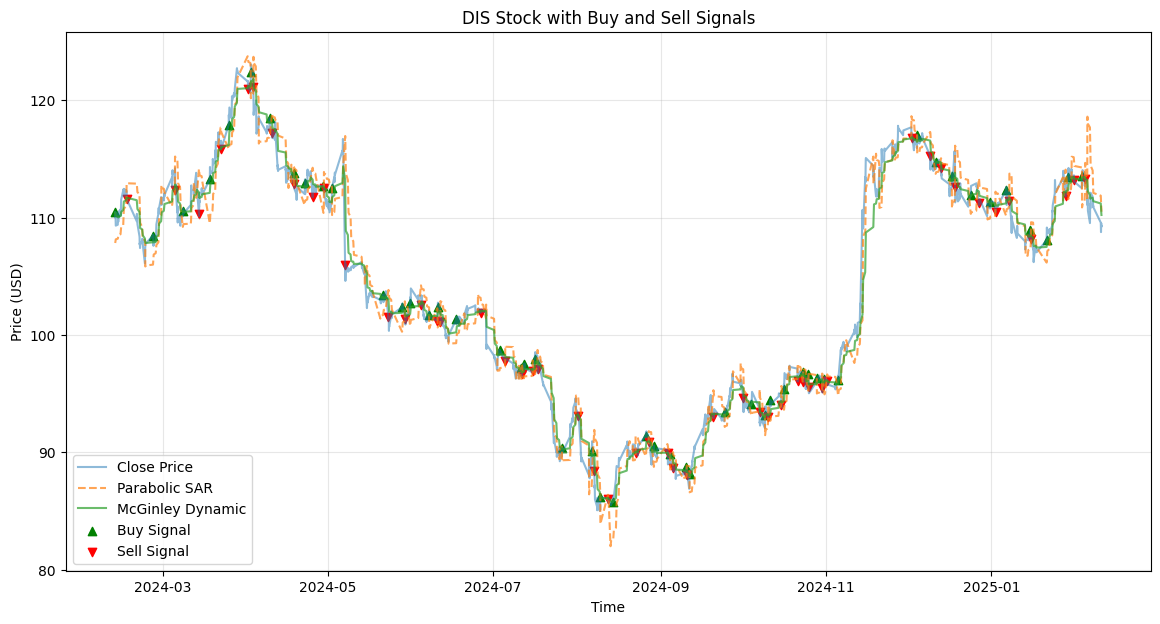

In [183]:
#Disney was on general downtrend mostly the year
plt.figure(figsize=(14, 7))


plt.plot(my_data['Close'], label='Close Price', alpha=0.5)


plt.plot(my_data['SAR'], label='Parabolic SAR', linestyle='--', alpha=0.7)


plt.plot(my_data['McGinley'], label='McGinley Dynamic', alpha=0.7)


buy_signals = my_data[my_data['Signal'] == 'Buy']
sell_signals = my_data[my_data['Signal'] == 'Sell']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', alpha=1)

# Add title, labels, and legend
plt.title("DIS Stock with Buy and Sell Signals")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend(loc='best')  # Ensure the legend appears with all labels
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [184]:
#now running over multiple symbols in various sectors
tickers = [
   # Technology
   "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "IBM", "INTC", "AMD",


   # Finance
   "JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "V", "MA", "PYPL",


   # Healthcare
   "JNJ", "PFE", "MRK", "ABBV", "UNH", "TMO", "GILD", "BMY", "LLY", "AMGN",


   # Energy
   "XOM", "CVX", "COP", "OXY", "BP", "SLB", "HAL", "VLO", "ENB",


   # Consumer Discretionary
   "DIS", "NKE", "SBUX", "HD", "LOW", "MCD", "TGT", "WMT", "TSCO", "TJX",


   # Consumer Staples
   "KO", "PEP", "PG", "CL", "KMB", "MO", "PM", "WBA", "KR", "GIS",


   # Industrials
   "CAT", "BA", "MMM", "GE", "HON", "DE", "LMT", "RTX", "NOC", "UPS",


   # Real Estate
   "PLD", "AMT", "CCI", "EQIX", "DLR", "PSA", "O", "SPG", "WY", "VTR",


   # Utilities
   "DUK", "NEE", "SO", "EXC", "AEP", "D", "SRE", "XEL", "ED", "PEG",


   # Communication Services
   "T", "VZ", "TMUS", "CMCSA", "NFLX", "CHTR", "FOX", "PARA",


   # Materials
   "LIN", "APD", "SHW", "ECL", "FCX", "NUE", "DOW", "MLM", "ALB", "IP",


   # Transportation
   "FDX", "DAL", "LUV", "UAL", "CSX", "NSC", "JBHT", "UPS", "CHRW",


   # Retail
   "COST", "AMZN", "WMT", "BBY", "HD", "LOW", "TGT", "DG", "DLTR", "BJ",


   # Semiconductors
   "TSM", "AMD", "NVDA", "INTC", "QCOM", "MU", "TXN", "AVGO", "ASML", "NXPI",


   # Crypto and Blockchain
   "COIN", "MSTR", "RIOT", "MARA", "HUT", "BTBT", "GBTC", "ETHE", "BITF", "BKKT",


   # International (ADRs)
   "BABA", "TSM", "NIO", "TCEHY", "JD", "BYND", "RY", "TD", "HSBC", "SAN",


   # Miscellaneous/Volatile
   "PLTR", "ARKK", "BB", "GME", "AMC", "SOFI", "RIVN", "LCID", "FVRR", "AFRM",
]


In [185]:
#run strategy for all various tickers in minutely fashion over a short time period(8 days)
#profit is not so good
profit = 0.0
for ticker in tickers:
   current_data =  do_strat_from_ticker_minute_wise(ticker)
   buy_prices = []
   sell_prices = []
   current_data[['Signal', 'Buy Price', 'Sell Price']] = current_data.apply(generate_signals, axis=1, result_type='expand')


print("Total Profit: ")
print(profit)
print("Average Profit per symbol: ")
print(profit / len(tickers))


Total Profit: 
-473.0146961212158
Average Profit per symbol: 
-2.8494861212121436


In [186]:
#run strategy for all various tickers in hourly fashion over a longer time period(1 year)
#much better profit
profit = 0.0
for ticker in tickers:
   current_data =  do_strat_from_ticker_hourly_wise(ticker)
   buy_prices = []
   sell_prices = []
   current_data[['Signal', 'Buy Price', 'Sell Price']] = current_data.apply(generate_signals, axis=1, result_type='expand')


print("Total Profit: ")
print(profit)
print("Average Profit per symbol: ")
print(profit / len(tickers))


Total Profit: 
1702.0533655881882
Average Profit per symbol: 
10.253333527639688
